[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/adams/blob/master/demos/feedforward_networks/nn_foundations.ipynb) 

In [17]:
# Import standard libraries
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Foundations of Feedforward Neural Networks
 
This notebook will revisit the lecture sessions on the foundations of artificial neural networks. We will review the forward and backward path and implement our own NN for regression from scratch.

The material in this notebooks draws on a 3-part blog series on NNs and the associated GitHub repository. The codes have been adjusted to match the notation introduced in the lecture. If you would like to check out the original sources, you can find them here:

*Blog series:*
- https://towardsdatascience.com/back-propagation-the-easy-way-part-1-6a8cde653f65
- https://towardsdatascience.com/back-propagation-the-easy-way-part-2-bea37046c897
- https://towardsdatascience.com/back-propagation-the-easy-way-part-3-cc1de33e8397

*Repository*
https://gist.github.com/ZSalloum/54703842f8a06e38fd76934579a6c814

In the following, we consider a simple feed-forward network with an input, two hidden, and one output layer.
<img src='./image/NN_01.png' alt='Feed-Forward Neural Network'/>

## Input Layer 
Let us first review the input layer. The input to our NN is just data. More specifically, we consider input in the form of an individual data point. More formally, our NN input is a column vector $X \in \mathbb{R}^{m}$ with $m$ denoting the number of features: \begin{equation}X = 
\begin{pmatrix}
x_{1} \\
x_{2}\\
\vdots\\
x_{m} 
\end{pmatrix}\end{equation}

<img src='./image/NN_02.png' alt='Input-Layer of the NN'/>

We use `sklearn` to create some synthetic data for regression.
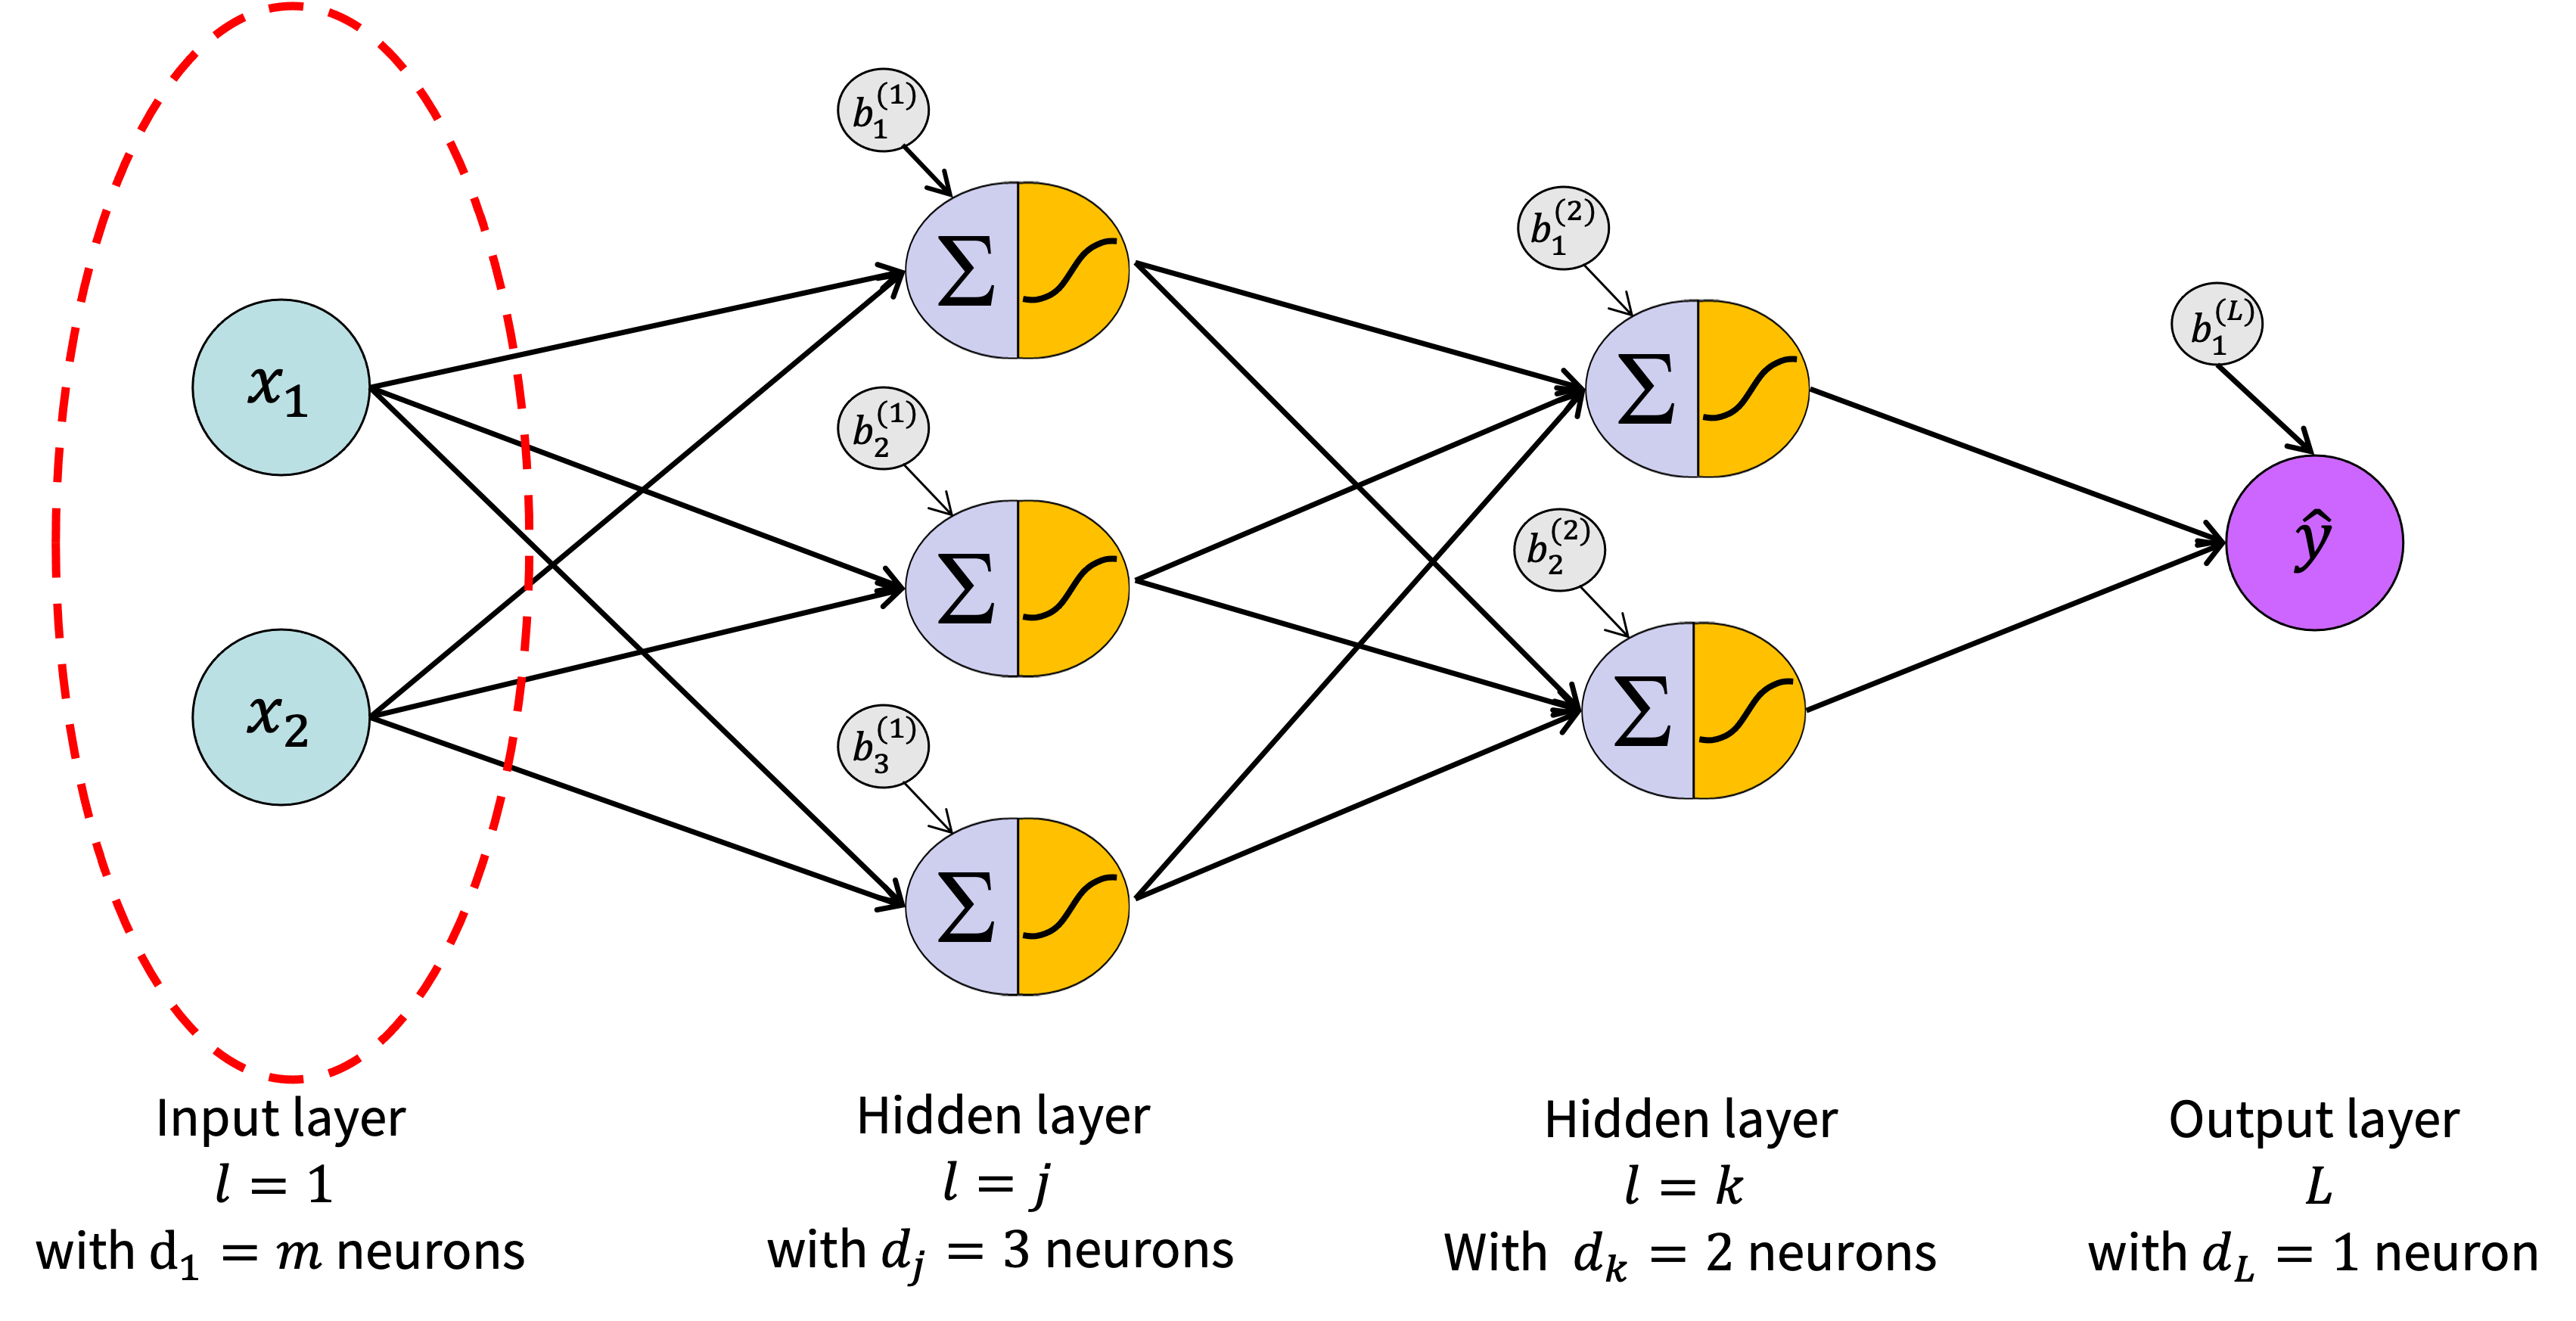

In [18]:
# generate 2d regression dataset with n = 250
from sklearn.datasets import make_regression
n = 250
m = 2
X, y = make_regression(n_samples=n, n_features = m, noise=1, random_state = 888)
y = y.reshape(n,1)  # turn y into a 1d vector
print(X.shape, y.shape)

(250, 2) (250, 1)


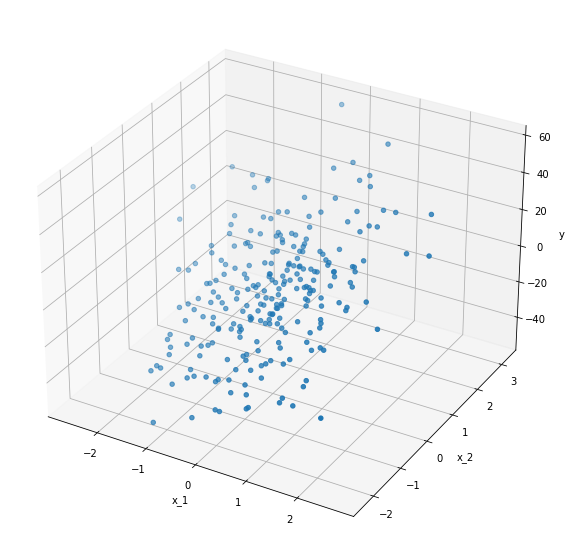

In [19]:
# Visualize the data as a scatter plot
from mpl_toolkits.mplot3d import Axes3D
df = pd.DataFrame(dict(x_1=X[:,0], x_2=X[:,1], y=y.ravel()))
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x_1'], df['x_2'], df['y'])
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_zlabel('y')
plt.show()

## Forward Pass
Having obtained some data, we are ready to compute the forward path. That is, we put each data point through the NN and compute the NN output. To that end, we need to define connection weights.

<img src='./image/NN_03.png' alt='Connections with weights and biases'/>

### Connection weights
We use the following notation. 

$ W^{(l)} $ denotes the matrix of the weights connecting layer $l-1$ to layer $l$. We denote elements of the matrix (i.e., individual weights) by $ w^{(l)}_{kj} $. The dimensionality of each weight matrix in the NN is $ k^{l-1} \times k^{l}$. So for the first weight matrix, which connects the input layer to the first hidden layer, we have:

\begin{equation} \Large W^{(1)}_{2 \times 3}  = 
\begin{pmatrix}
w_{11} & w_{12} & w_{13}\\
w_{21} & w_{22} & w_{23}
\end{pmatrix} 
\end{equation}
Recall that for the dimensinality of the input layer is always equal to $m$, the number of features.

Question to check your understanding: 
For our examplary NN, what are the dimensions of the weights matrixes $W^{(2)}$ and $W^{(L)}$?

To proceed with calculating the forward path, we initialize the weights randomly. 

In [20]:
# Random weight initialization
np.random.seed(10)
dim = (2,3)
w = 2 * np.random.random(dim) 
print("W = ", w)


W =  [[1.54264129 0.0415039  1.26729647]
 [1.49760777 0.99701402 0.44959329]]


*Please note: This is where we would usually also initialise the weights for the bias. However, to simplify the task and focus on the understanding of the task, we are leaving out the bias at this point.*

### Hidden Layers
<img src='./image/NN_04.png' alt='Hidden layer'/>
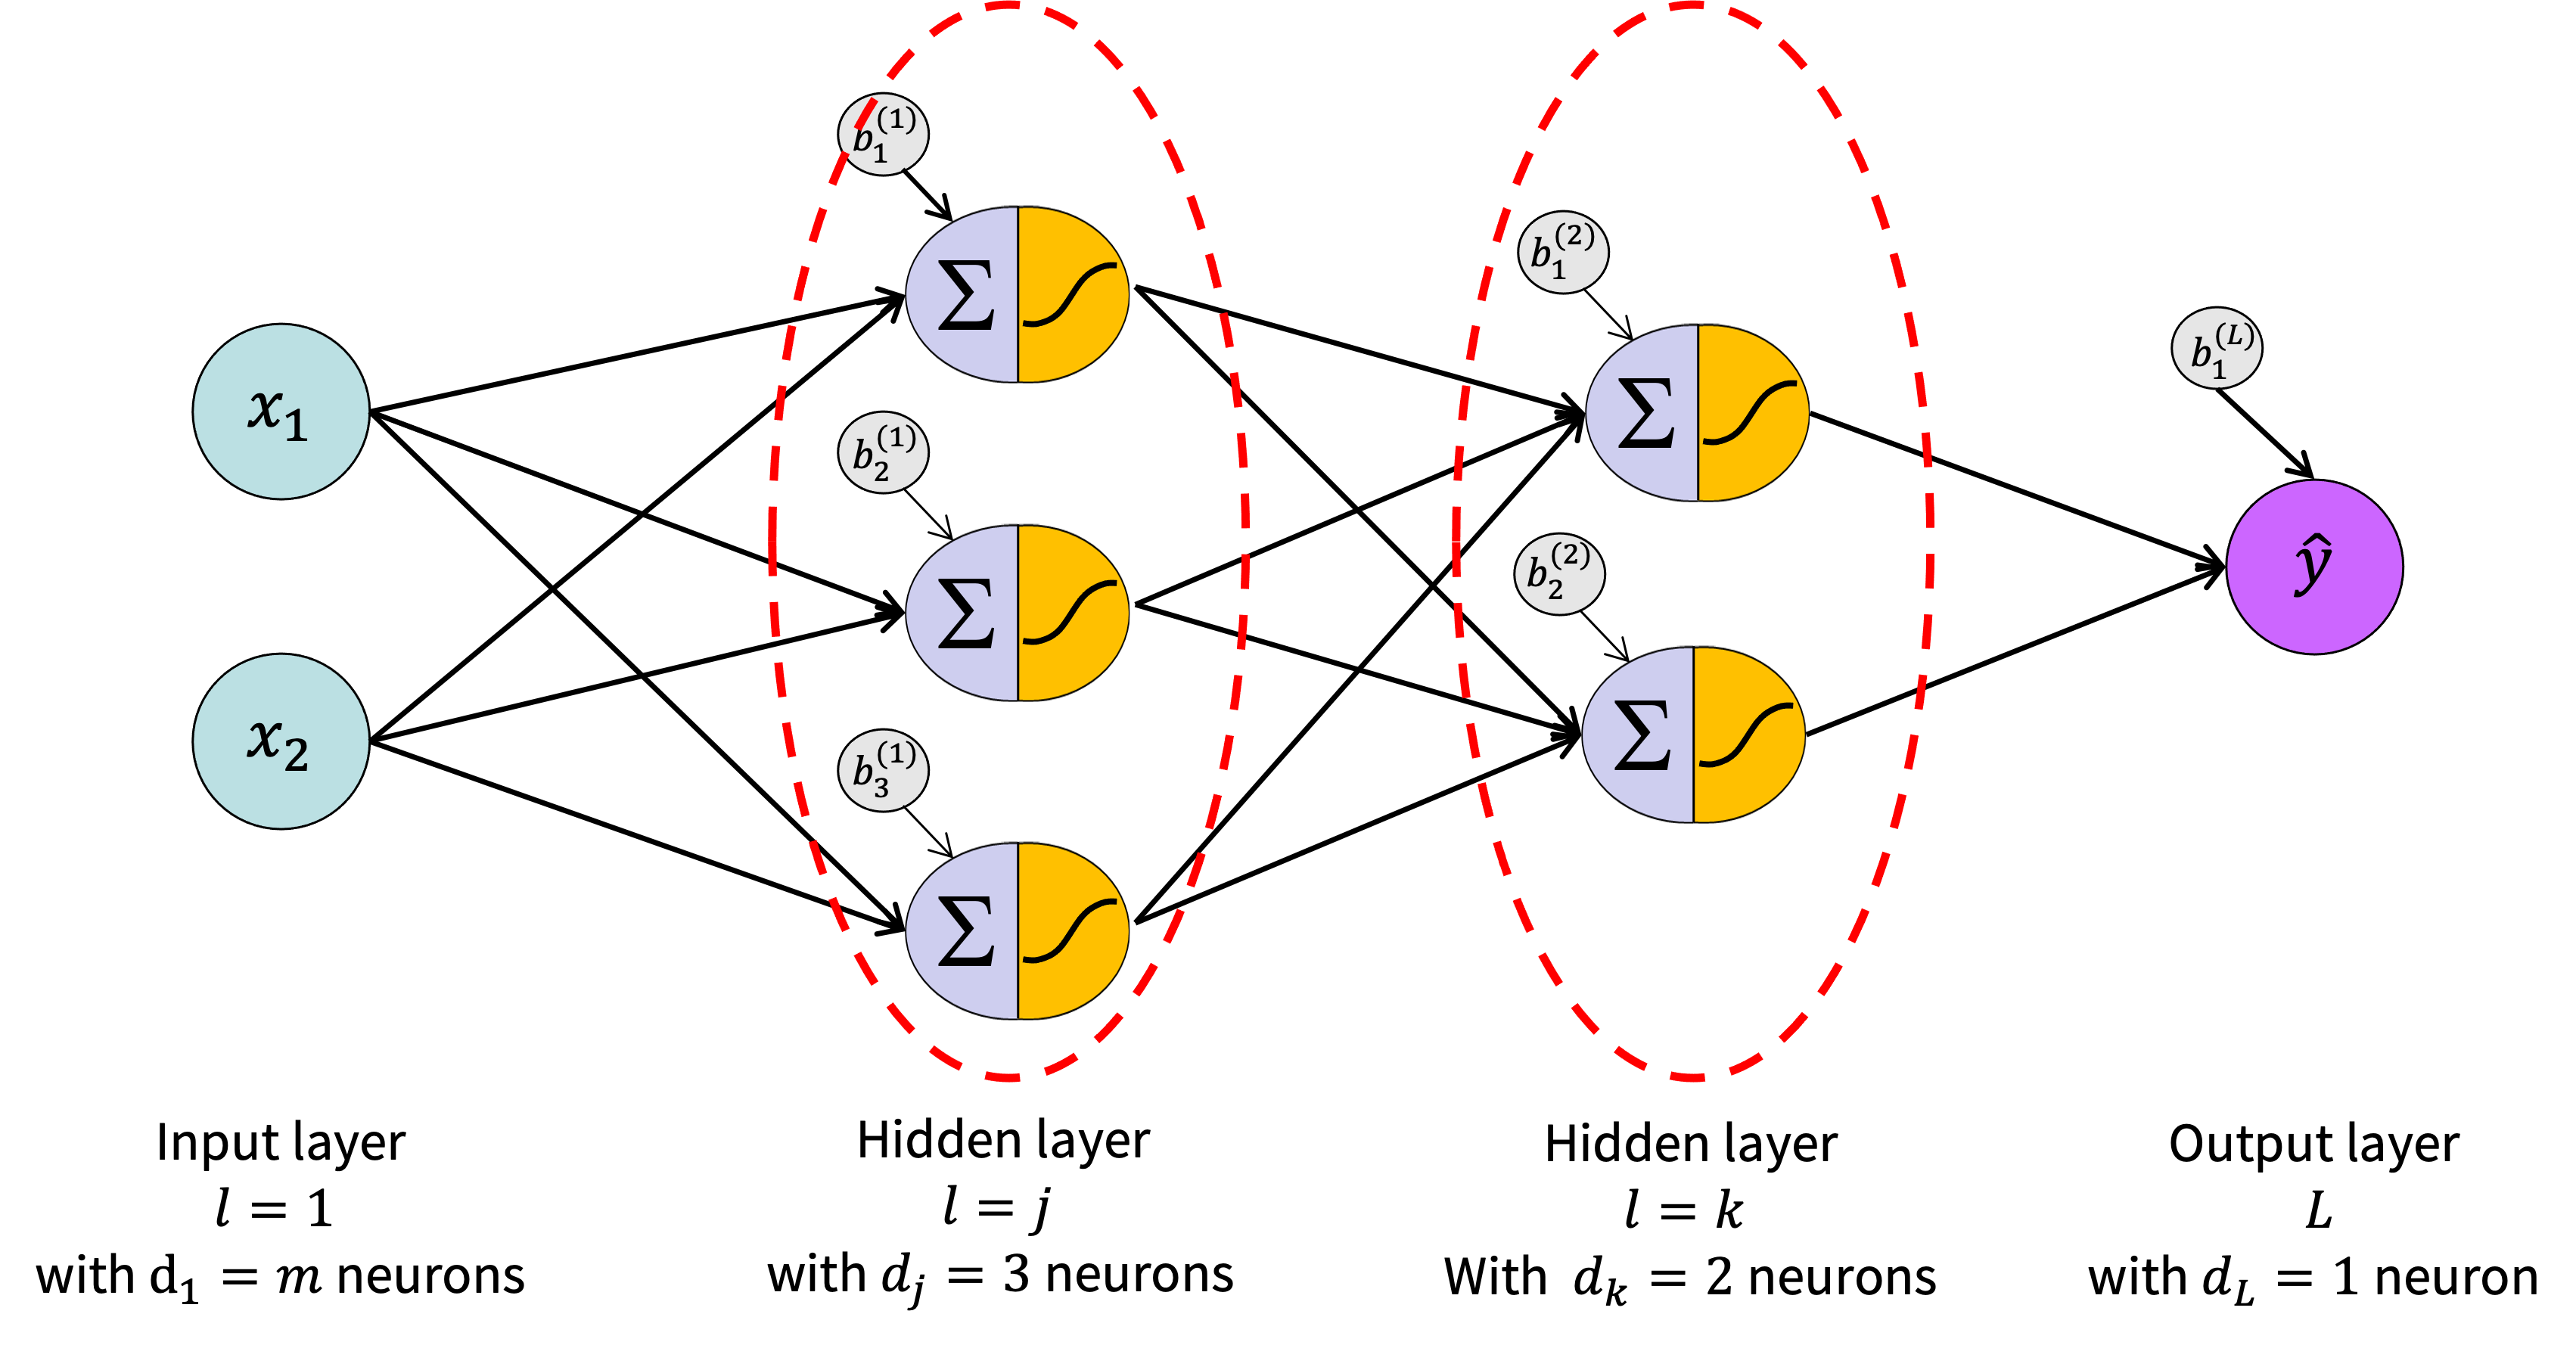

### Hidden Layer Step 1: Calculate Z

To be able to calculate the input of a hidden layer, $Z$, we simply compute the scalar product of the weights and the output of the previous layer. For the first hidden layer, the output of the previous layer is just the data. 

In [21]:
# Scalar product for a single data point:
i=0
z = np.dot(X[i,:], w)
print("When inputting a single data point, we obtain:",z.shape)

# In practice, we would input the entire data at once
Z = np.dot(X, w)
print("When inputting the entire training data, we obtain:",Z.shape)

When inputting a single data point, we obtain: (3,)
When inputting the entire training data, we obtain: (250, 3)


*Please note: If working with the bias, we would simply add it here.

### Hidden Layer Step 2: Calculate h / Activation Functions
- Notation: 
\begin{equation} \Large H^{(l)} = g(Z^{(l)}) \end{equation}


\begin{gather}
 \begin{pmatrix}
           h^{(1)}_{1}\\
           h^{(1)}_{2}\\
           h^{(1)}_{3}
         \end{pmatrix}
 = 
 \begin{pmatrix}
           g(z^{(1)}_{1})\\
           g(z^{(1)}_{2})\\
           g(z^{(1)}_{3})
         \end{pmatrix}
\end{gather}
During the forward pass, we only need the activation function, but for simplicity and because we need this knowledge for the backpropagation part, we will also discuss the derivatives of the activation functions. Also, during the forward pass, we will always store the result of the derivative as well to work more efficient and use less computational power. 

###### Function for plotting of activation function 

In [22]:
# Helper function to plot common activation functions (you can skip this part)

def plot_activation_functions(type="sigmoid"):
  
  n = 100 
  z=np.linspace(start=-5, stop=5, num=n)

  if type == "sigmoid":
    def sigmoid(z):
      return 1.0 / (1.0 + np.exp(-z))

    def sigmoid_prime(z):
      return sigmoid(z) * (1.0 - sigmoid(z))

    plt.plot(z, sigmoid(z), 'b-', label="g(z)")
    plt.plot(z, sigmoid_prime(z), 'r-', label="g'(z)")
    plt.legend(loc='best')
    plt.grid(True)
    plt.xlabel('z')
    plt.ylabel('g(z)')
    plt.show()
  
  if type == "tanh":
    def tanh(z):
      return np.tanh(z)
    def tanh_prime(z):
      return 1.0 - np.tanh(z) ** 2

    plt.plot(z, tanh(z), 'b-', label="g(z)")
    plt.plot(z, tanh_prime(z), 'r-', label="g'(z)")
    plt.legend(loc='best')
    plt.grid(True)
    plt.xlabel('z')
    plt.ylabel('g(z)')
    plt.show()

  if type == "relu":
    def relu(z):
      return np.maximum(z,0)
    def relu_prime(z):
      z[z <= 0] = 0
      z[z > 0] = 1
      return z
      
    some_var=np.linspace(start=-5, stop=5, num=n)
    g=np.maximum(0, some_var)
    d=(g>1).astype(int)
    plt.plot(z, np.maximum(0, z), 'b-', label="g(z)")
    plt.plot(z, (g>1).astype(int), 'r-', label="g'(z)")
    plt.legend(loc='best')
    plt.grid(True)
    plt.xlabel('z')
    plt.ylabel('g(z)')
    plt.show()


#### Sigmoid



\begin{equation} \Large g(z) = σ(z) = \frac{1}{{1+e^{-z}}} \end{equation}

#### Sigmoid derivative

\begin{equation} \Large g'(z) = σ'(z) = σ(x) (1−σ(x)) \end{equation}



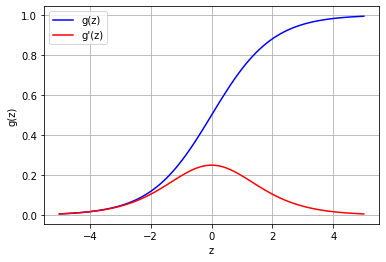

In [23]:
plot_activation_functions(type="sigmoid")

# Defining functions in python
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


def sigmoid_prime(x):
    return sigmoid(x) * (1.0 - sigmoid(x))



#### Hyperbolic Tangent (tanh)


\begin{equation} \Large g(z) = tanh(z) = \frac{e^z-e^{-z}}{e^z+e^{-z}} \end{equation}

#### Hyperbolic Tangent derivative
\begin{equation} \Large g'(z) = tanh'(z) = 1-tanh(z)^2 \end{equation}


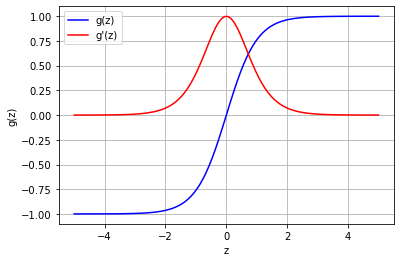

In [24]:
plot_activation_functions(type="tanh");



def tanh(x):
    return np.tanh(x)


def tanh_prime(x):
    return 1.0 - np.tanh(x) ** 2



####  Rectified Linear Unit (ReLU)


\begin{equation} \Large g(z) = ReLU(z) = max(0,z) \end{equation}

#### ReLU derivative

\begin{equation} \Large
g'(z)=  ReLU'(z) =
\begin{cases}
    0 & \text{if } z < 0 \\ 1 & \text{if } z > 0
\end{cases}
\end{equation}

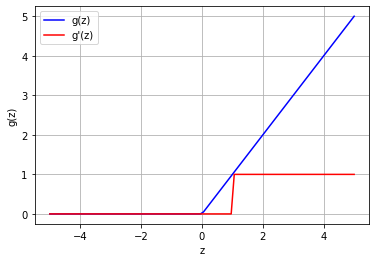

In [25]:
plot_activation_functions(type="relu")

def relu(x):
    return np.maximum(x,0)


def relu_prime(x):
    x[x <= 0] = 0
    x[x > 0] = 1
    return x

## Output Layer

In this step, we continue just like before, however, we do not incorporate the activation function, meaning our result is $z$ for the output layer.

<img src='./image/NN_05.png' alt='Output layer'/>

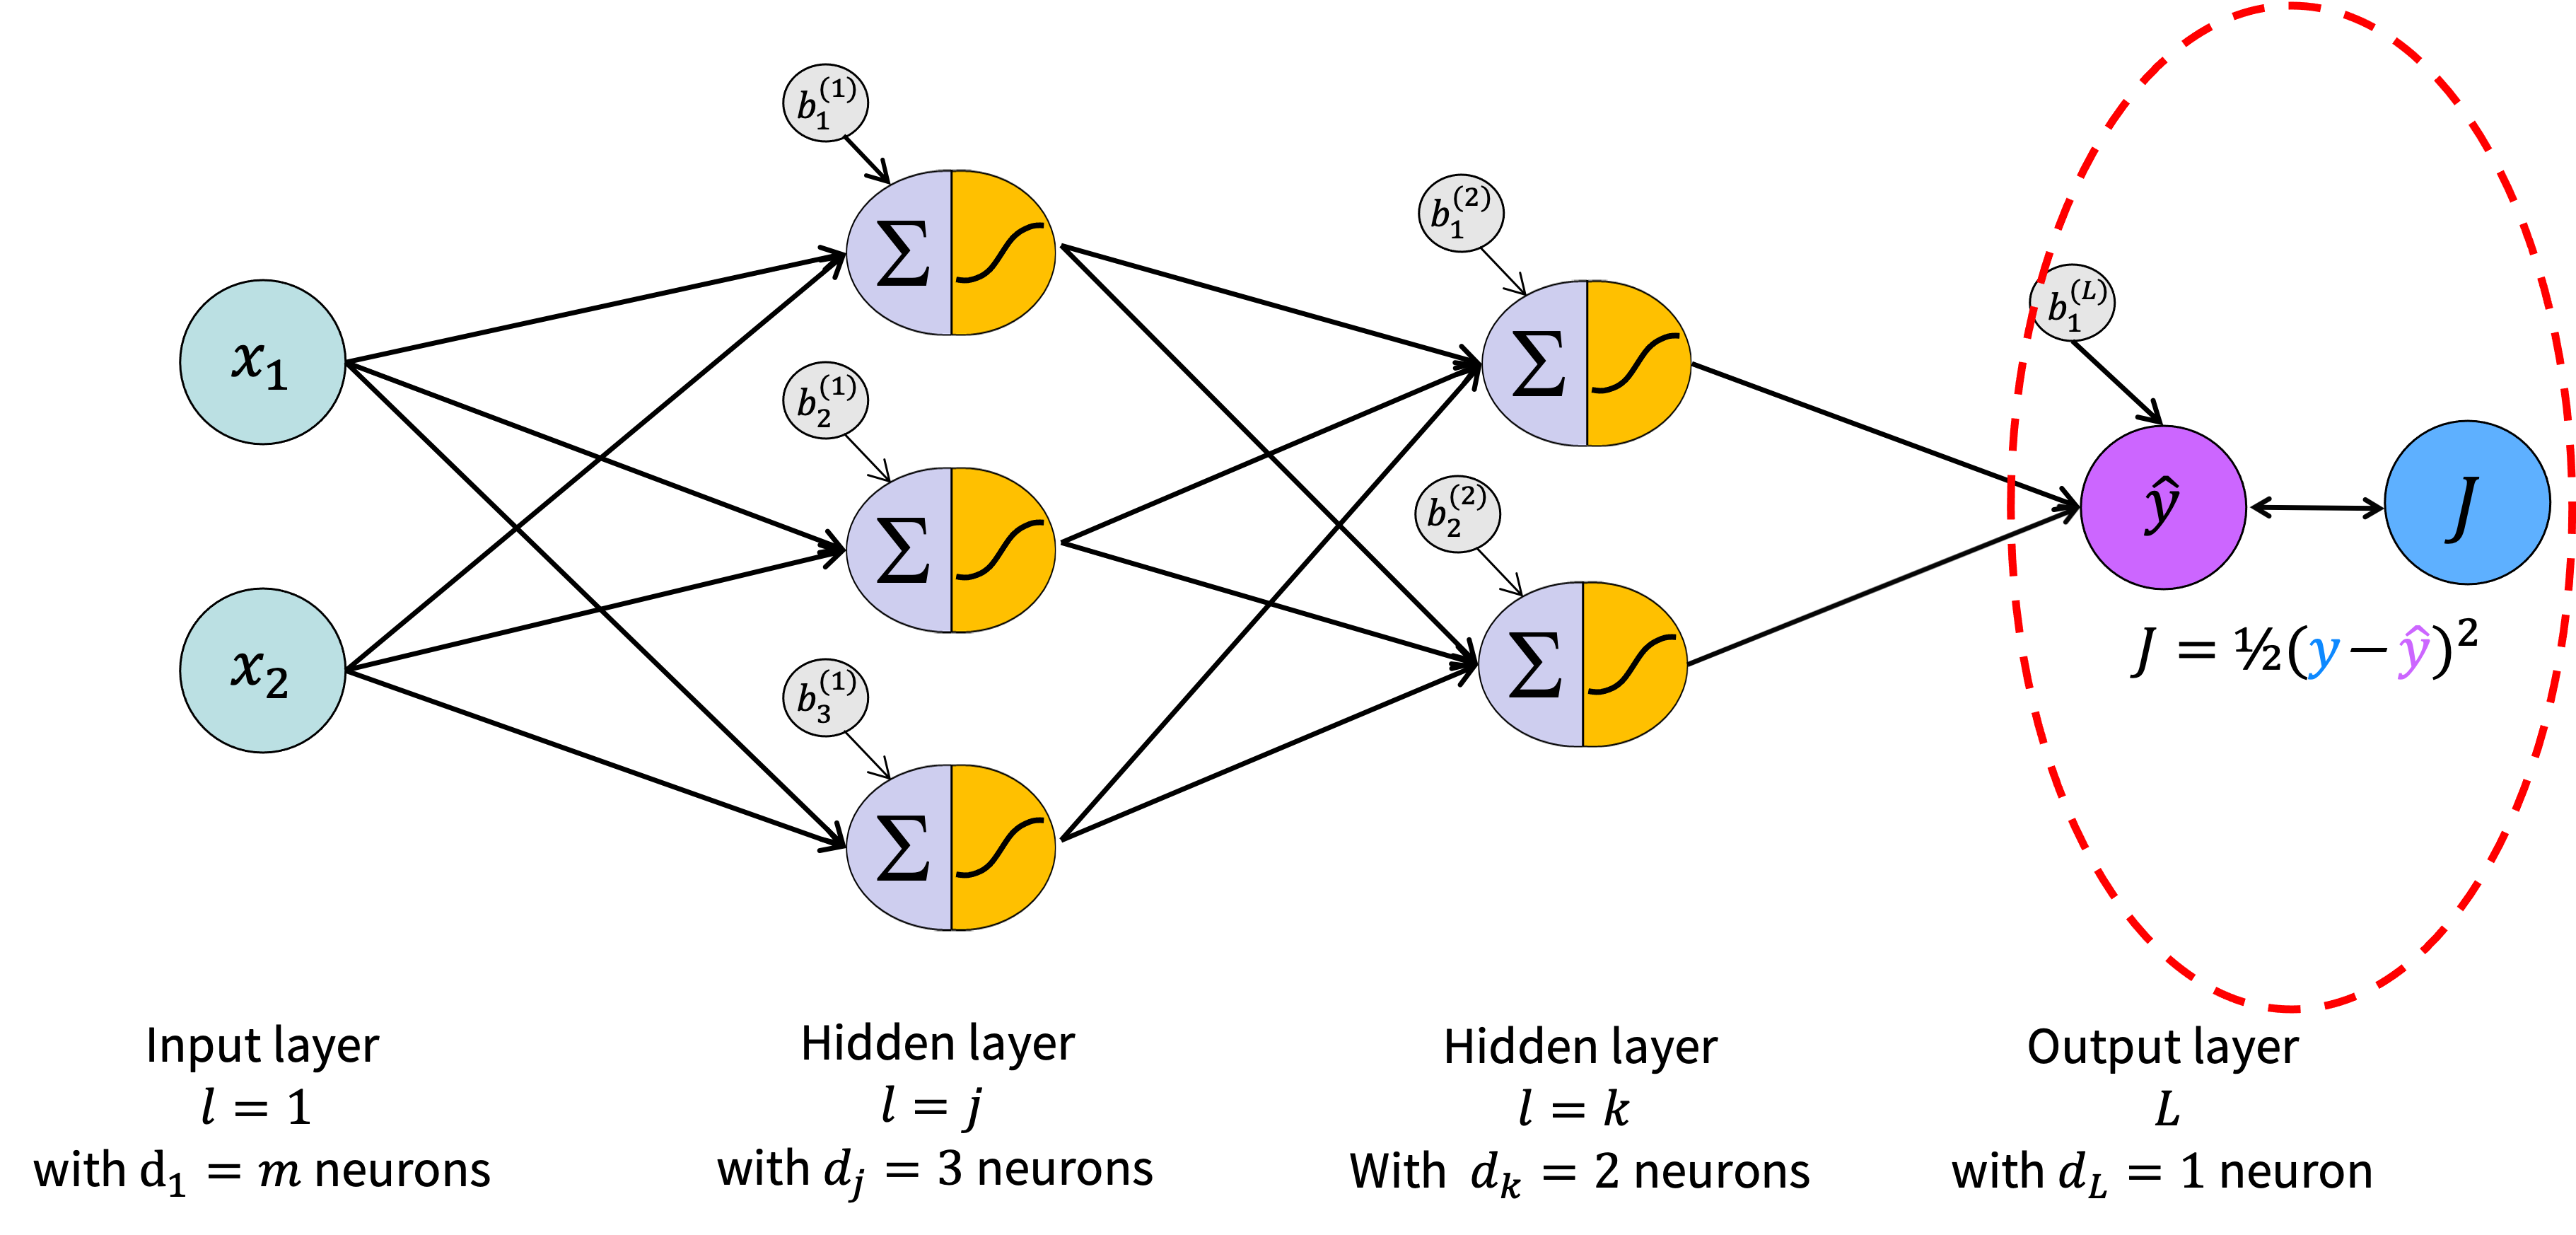

## Implementation of the NN

### Forward path

Now that the basics have been discussed, let's have a closer look at how we can implement the forward path.

In [26]:
np.random.seed(10)
d = [2,3,2,1] # nodes per layer
W = [] # saving the weights so we can analyse them
h = X[0] # our first h equals the input layer, meaning the values for x_1 and x_2. We will be working with one oberservation for better understanding.
Z = [] # save Z for analysis 
H = [] # save H to analyse
Z_prime = []

for i, (previous, current) in enumerate(zip(d, d[1:])):
    #initialise weights
    dim = (previous, current)
    w = 2 * np.random.random(dim) 
    W.append(w)
    z = np.dot(h, w)  # note that we consider a single element of X
    H.append(h)
    Z_prime.append(sigmoid_prime(z))
    if i != len(d)-2: # -1 for subsitution of input layer, -1 for index starting at 0 = -2
        h = sigmoid(z)  # we consider sigmoid activation in the example but any other activation function would also be ok
    else:
        h = z # no activation in output layer
    print("         dimensions,    matrice")
    print("Layer", i+1)
    print("Weight:", w.shape, w)
    print("Z:", z.shape, z)
    print("H:", h.shape, h)

         dimensions,    matrice
Layer 1
Weight: (2, 3) [[1.54264129 0.0415039  1.26729647]
 [1.49760777 0.99701402 0.44959329]]
Z: (3,) [1.14701829 0.00550675 0.96297667]
H: (3,) [0.75896587 0.50137668 0.72371739]
         dimensions,    matrice
Layer 2
Weight: (3, 2) [[0.39612573 1.52106142]
 [0.33822167 0.17667963]
 [1.37071964 1.90678669]]
Z: (2,) [1.46223601 2.62299144]
H: (2,) [0.81187443 0.93232669]
         dimensions,    matrice
Layer 3
Weight: (2, 1) [[0.00789653]
 [1.02438453]]
Z: (1,) [0.96147203]
H: (1,) [0.96147203]


Question to check your understanding: What is the output of the NN?

Suggested task to challenge your coding skills: The above examples considers the first data point in the input data matrix $X$. Extend the code to process all data items, and/or extend the code to process the entire matrix $X$ at once.

### Object-orientation
Drawing on the blog post mentioned above, we can improve our implementation of the forward path making use of object-oriented programming. The point of this revised implementation is to shed light on how one would implement NNs in practice, and how it is done in principle in libraries like `sklearn`. 

We begin with designing a class to represent the layers of a NN. From a programming perspective, the below class contains just the same functionality that we have demonstrated above.

In [27]:
# object-oriented 
np.random.seed(99)
class Layer:

    def __init__(self, dim, id, act, act_prime, isoutputLayer = False): 
        # dim = dimensions of the weight matrix [d_l, d_(l-1)]
        # id: integer of id of the layer
        # act and act prime: the activation function and its derivative
        # isoutputLayer: true if its the output layer
        self.weight = 2 * np.random.random(dim) - 1 # the weight for each node
        self.delta = None # create empty variable to store delta 
        self.H = None # create emtpy varaible for activation (h)
        self.activation = act # define activation
        self.activation_prime = act_prime # define action of derivative of activation function calculation # todo rephrase 
        self.isoutputLayer = isoutputLayer # different action in the output layer 
        self.id = id # node identification

    def forward(self, x):
        z = np.dot(x, self.weight) # matrix calculation of input into layer (either X or H)
        self.H = self.activation(z) # create h from z by using activation function 
        self.dZ = self.activation_prime(z); # store the prime of the activation function for backpropagation alter to safe computational power

        return self.H

### Loss Function
Initially, we set the parameters in our NN, the connection weights, randomly. We can expect the NN output to be very far away from the actual output $Y$, which we would like to predict. To improve this, we train the NN. A key ingredient to NN training is a loss function, which measures how good or bad the NN output $\hat{Y}$ matches the actually observed output $Y$. 

<img src='./image/NN_06.png' alt='Loss surface'/>    
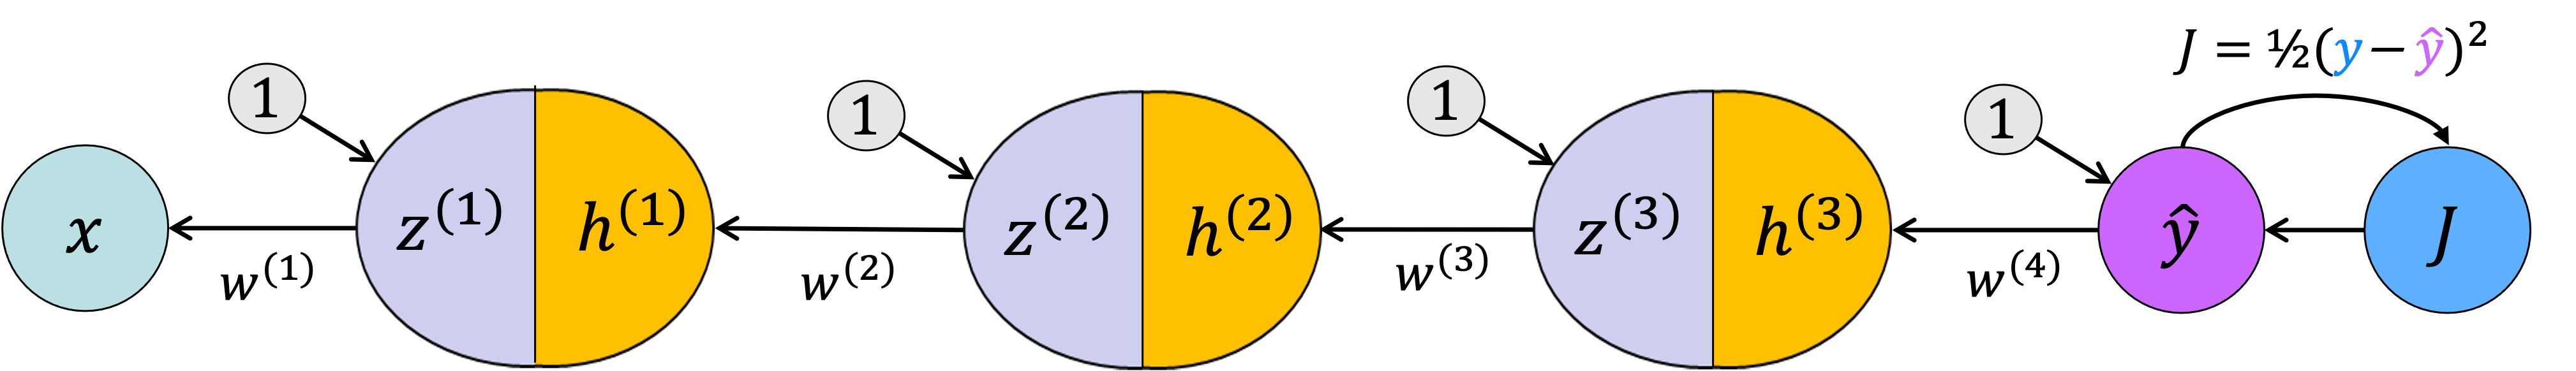

As shown in the above picture, we use a simple, well-behaved loss function, the squared-error loss function. 

\begin{equation} \Large J = \dfrac{1}{2}(y-\hat{y})^2\end{equation}

With this loss function, we can calculate the deviation from the predicted target $\hat{Y}$ to the actual target $Y$. Further, we can calculate the gradient of the loss with respect to the NN parameters (i.e., weights). 

\begin{equation} \Large \dfrac{\partial J(W_{t})}{\partial W_t}  \end{equation}

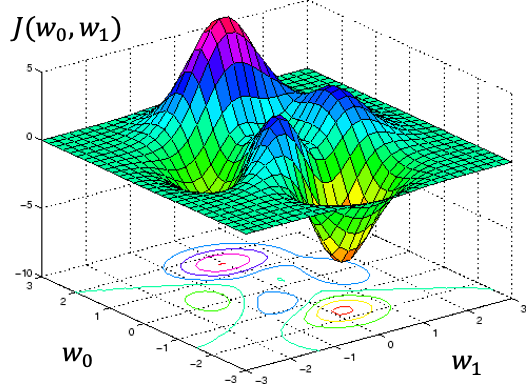

### Calculating Partial Derivative and Deltas
The calculations of the partial derivates of the loss with respect to individual weights has been discussed extensively in the lecture. We won't repeat it here. The key equation for computing gradients was: 

\begin{equation} \Large \dfrac{\partial J(W_{t})}{\partial W_t}= \delta^{(l)} h^{(l-1)}\end{equation}

with $h^{(l-1)}$ being the output of the layer to the left and $\delta$ having to be calculated differently based on whether or not it is the output layer. The current delta always depends on the delta to the right, which is why we talk about backpropagation: starting from the back to the beginning. 

For the output layer, and because we work with the squared error loss function, we have:

\begin{equation} \Large \delta^{(L)} = \hat{y}-y \end{equation}

For all other layers, we obtained:
\begin{equation} \Large \delta^{(l)} = ((w^{(l+1)})^T \delta^{(l+1)})g'(z^{(l)}) \end{equation}



<img src='./image/NN_07.png' alt='Backpropagation'/>    

Let's revisit these calculations in Python
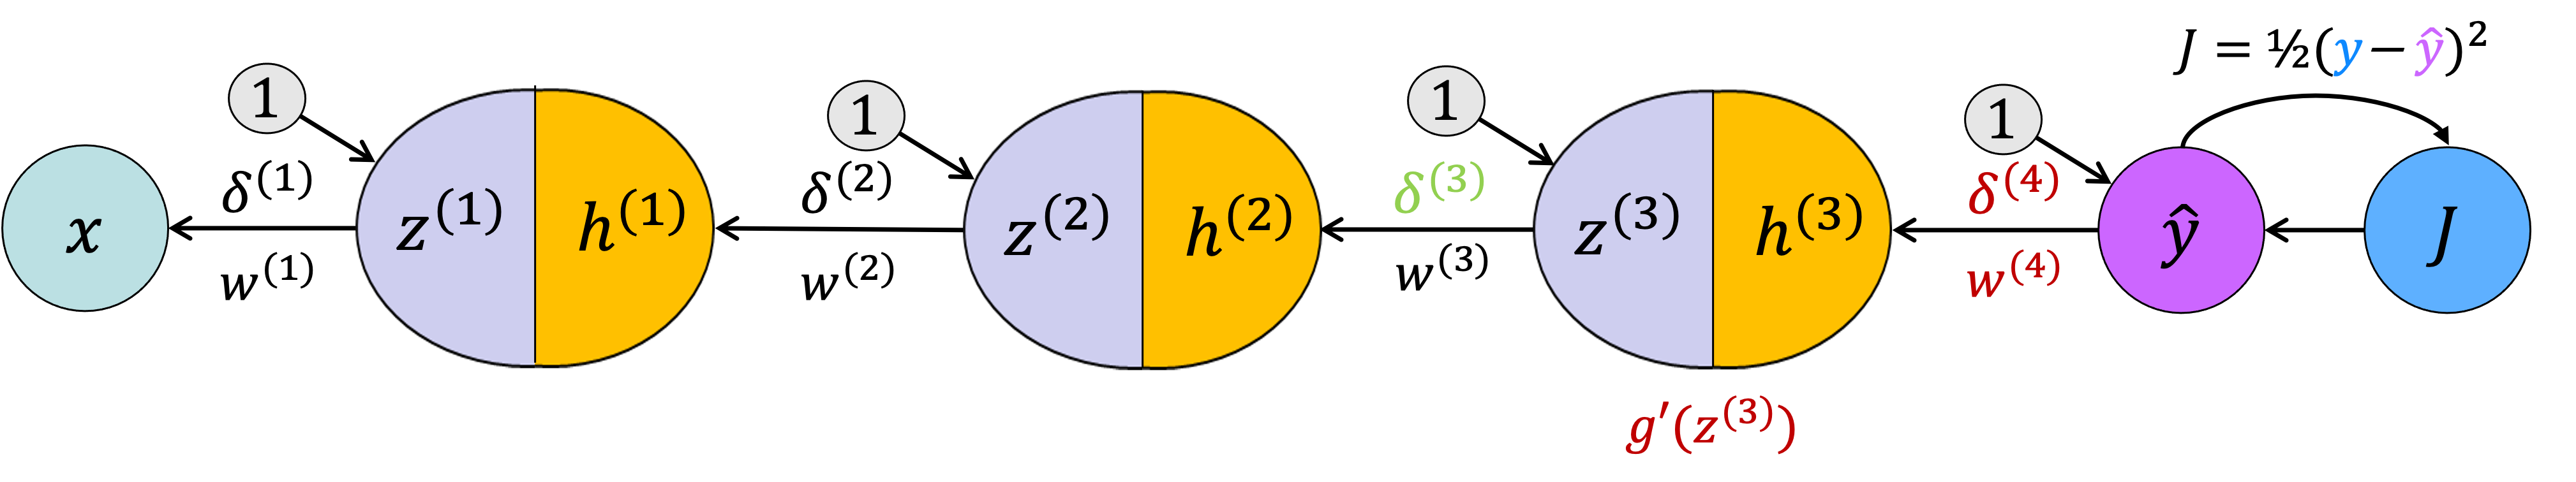

In [28]:
Delta = []

n_layers = 3 # amount of layers incl. output layer exl. input layer
for layer in reversed(range(1,n_layers)):
  print("Layer:", layer)
  if layer == n_layers-1:  # output layer
    error = h - y[0]
    delta = error
  else:
    delta = delta * Z_prime[layer+1] * W[layer+1][0]
  print(delta)
  Delta.append(delta)

Delta.append(0) # necessary because for the layer 0 (input) there is no delta, so we need to fil this gap to be able to properly reference the correct numbers
Delta.reverse()

Layer: 2
[-3.93278294]
Layer: 1
[-0.00621371]


*Please note that we will be mulitplying delta with h^(l-1) directly in the update part.*

<img src='./image/NN_08.png' alt='Computing gradients and deltas'/>    


As before, we can enhance the implementation with a nice object-oriented design. Thus, we extend the class `Layer` that we started to implement above.
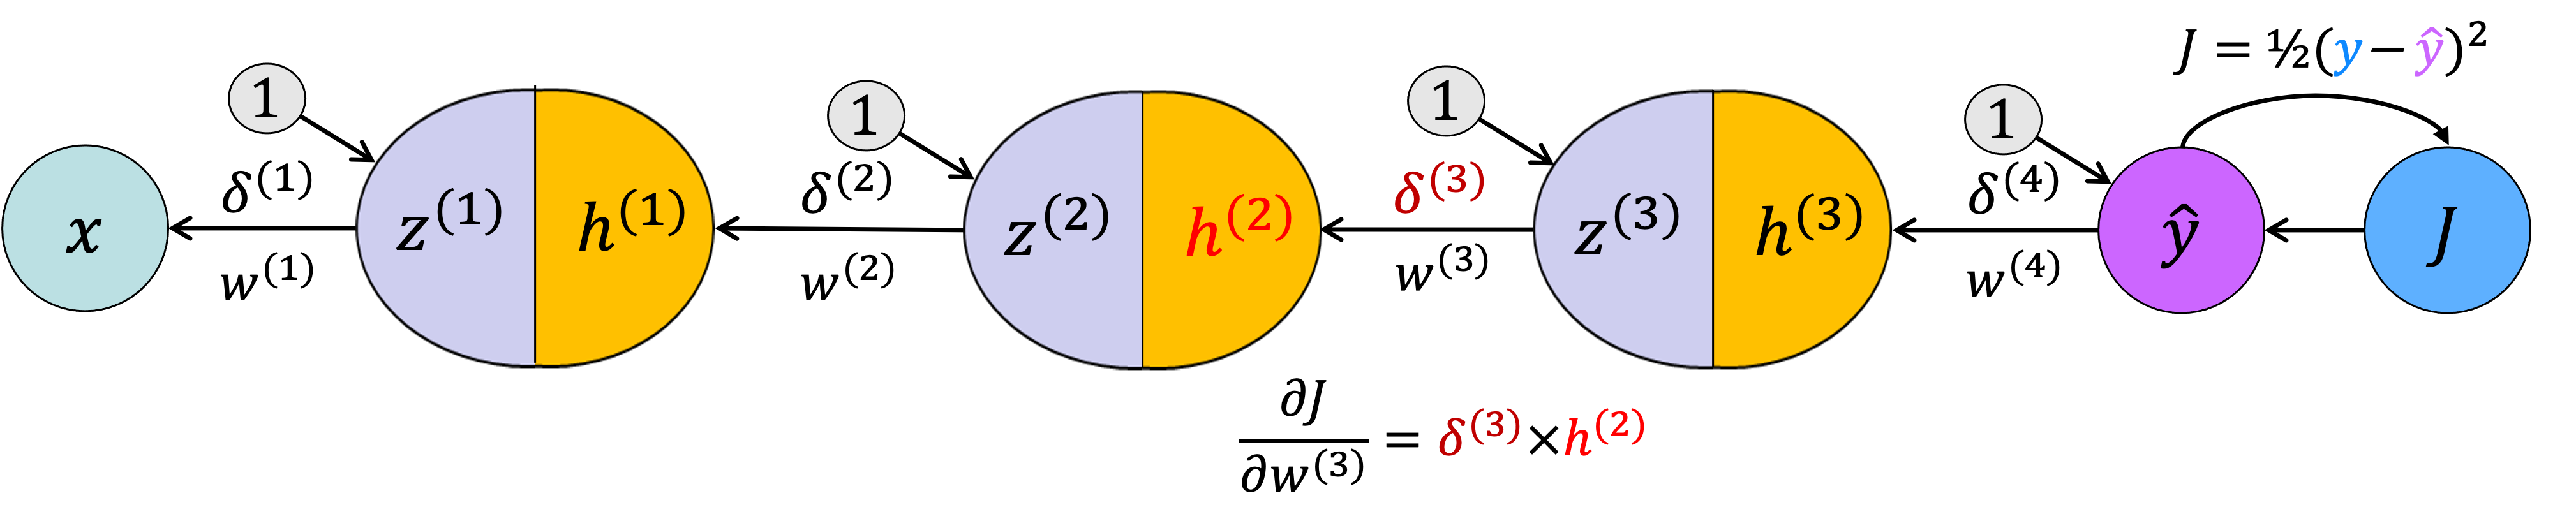

In [29]:
# object-oriented 
class Layer:    
    def backward(self, y, rightLayer):
        if self.isoutputLayer:
            error =  self.H - y 
            self.delta = error
        else:
            self.delta = np.atleast_2d(
                rightLayer.delta.dot(rightLayer.weight.T) # delta of right layer, weight of right layer, and derivative of activation function of this layer
                * self.dZ)
        return self.delta

### Update Weights
So, lastly, we need to update our weights. 


\begin{equation} \Large W_{t+1} ← W_t -η \dfrac{\partial J(W_{t})}{\partial W_t} \end{equation}
with $W_t$ being our current weight, $W_{t+1}$ being the new weight and $η$ being the learning rate (hyperparameter).

In [30]:
# Coding example
learning_rate = 0.1 # set learning rate
W_new = [] # save new weights
for layer in reversed(range(1,n_layers)):
  w_t1 = float(W[layer][0][0]- learning_rate*H[layer-1][0] * Delta[layer])
  W_new.append(w_t1)

print(W_new)

[0.3063813370741489, 0.39660373067234633]


In [31]:
# Object-oriented implementation
class Layer:
    def update(self, learning_rate, left_h):
        a = np.atleast_2d(left_h)
        d = np.atleast_2d(self.delta)
        hd = a.T.dot(d)
        self.weight -= learning_rate * hd  

## Summary

Now that we have seen the individual parts, we can put everything together to obtain our full implementation of the `Layer` class. Further, we add another class that abstracts the full NN, which is essentially a collection of layers. 

In [32]:
# object-oriented
class Layer:

    def __init__(self, dim, id, act, act_prime, isoutputLayer = False):
        self.weight = 2 * np.random.random(dim) - 1
        self.delta = None
        self.H = None
        self.activation = act
        self.activation_prime = act_prime
        self.isoutputLayer = isoutputLayer
        self.id = id


    def forward(self, x):
        z = np.dot(x, self.weight)
        self.dZ = np.atleast_2d(self.activation_prime(z));
        if self.isoutputLayer:
          self.H = z
        else:
          self.H = self.activation(z)
        return self.H

    def backward(self, y, rightLayer):
        if self.isoutputLayer:
            error = self.H - y
            self.delta = error
            te = (pow(error, 2))
            total_error.append(np.average(0.5*te))
            
        else:
            self.delta = np.atleast_2d(
                np.dot(rightLayer.delta, rightLayer.weight.T)
                * self.dZ)
            
        return self.delta

    def update(self, learning_rate, left_h):
        h = np.atleast_2d(left_h)
        d = np.atleast_2d(self.delta)
        hd = h.T.dot(d)
        self.weight -= learning_rate * hd
    


class NeuralNetwork:

    def __init__(self, layersDim, activation='tanh'):
        if activation == 'sigmoid':
            self.activation = sigmoid
            self.activation_prime = sigmoid_prime
        elif activation == 'tanh':
            self.activation = tanh
            self.activation_prime = tanh_prime
        elif activation == 'relu':
            self.activation = relu
            self.activation_prime = relu_prime

        self.layers = []
        for i in range(1, len(layersDim) - 1):
            dim = (layersDim[i - 1] + 1, layersDim[i] + 1)
            self.layers.append(Layer(dim, i, self.activation, self.activation_prime))

        dim = (layersDim[i] + 1, layersDim[i + 1])
        self.layers.append(Layer(dim, len(layersDim) - 1, self.activation, self.activation_prime, True))

    def fit(self, X, y, learning_rate=0.1, epochs=10000):
        np.random.seed(999)
        # Add column of ones to X
        # This is to add the bias unit to the input layer
        ones = np.atleast_2d(np.ones(X.shape[0]))
        X = np.concatenate((ones.T, X), axis=1)


        for k in range(epochs):


            h=X

            for l in range(len(self.layers)):
                h = self.layers[l].forward(h)


            delta = self.layers[-1].backward(y, None)

            for l in range(len(self.layers) - 2, -1, -1):
                delta = self.layers[l].backward(delta, self.layers[l+1])



            h = X
            for layer in self.layers:
                layer.update(learning_rate, h)
                h = layer.H

    def predict(self, x):
        h = np.concatenate((np.ones(1).T, np.array(x)), axis=0)
        for l in range(0, len(self.layers)):
            h = self.layers[l].forward(a)
        return h

# Training models

In [33]:
gd_plot = pd.DataFrame(columns=["sigmoid", "tanh", "relu"]) # create df for saving loss over epochs
epochs= 2000 # define amount of epochs

In [34]:
# train with sigmoid function
total_error = []
nn = NeuralNetwork([2, 3, 2, 1], activation='sigmoid')
nn.fit(X, y, learning_rate=0.0001, epochs=epochs)

gd_plot['sigmoid'] = total_error

In [35]:
# train with tanh function
total_error = []
nn = NeuralNetwork([2, 3, 2, 1], activation='tanh')
nn.fit(X, y, learning_rate=0.00001, epochs=epochs)

gd_plot['tanh'] = total_error

# Model Evaluation

To see if our model is working, we can see how the error developed based on our loss function.

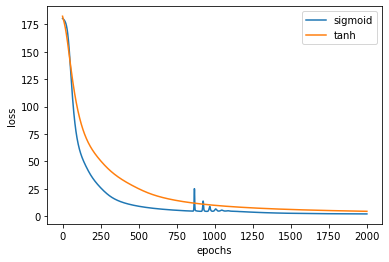

In [37]:
plt.plot(gd_plot.index, gd_plot['sigmoid'], label = "sigmoid")
plt.plot(gd_plot.index, gd_plot['tanh'], label = "tanh")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()